# Opening large CZI files with AICSImageIO

When working with large microscopy images (e.g. multiple GB to TB per file), the data may exceed your memory capacity, potentially causing the kernel to crash. 
In this notebook, we will use the `AICSImageIO` library integrated with `Dask` to handle large `.czi` files efficiently.

⚠️ Note: [`AICSImageIO`](https://github.com/AllenCellModeling/aicsimageio) is no longer actively maintained. If you run into issues while following this notebook, please try its compatible successor [`BioIO`](https://bioio-devs.github.io/bioio/OVERVIEW.html).



## Requirements

Before getting started, ensure that you have the necessary libraries for handling bioimage formats and `.czi` files installed. If not, please run these two commands in your command line:

    pip install aicsimageio  
    pip install aicspylibczi 

## Downloading Data

We will use the mouse brain image `Demo LISH 4x8 15pct 647.czi` from [Nicolas Chiaruttini](https://zenodo.org/records/8305531), licensed under [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode) and store it in a local directory.

First, let's confirm that the folder where we want to store the data exists - and create it if it does not. 

In [1]:
from aicsimageio import AICSImage
import os
import urllib.request

In [2]:
def ensure_folder_exists(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

In [3]:
folder_path = "../../data/"

In [4]:
ensure_folder_exists(folder_path)

Next, we will check if the file has already been saved in the directory. If not, we will download it. 

In [5]:
def ensure_file_exists(file_path, url):
    if not os.path.isfile(file_path):
        try: 
            print(f"Please wait. Downloading file from {url} to {file_path}...")
            urllib.request.urlretrieve(url, file_path)
            print("Download complete.")
        except Exception as e: 
            print(f"Download failed: {e}")
    else:
        print("File already exists.")

In [6]:
filename = "Demo LISH 4x8 15pct 647.czi"
file_path = os.path.join(folder_path, filename)
url = "https://zenodo.org/records/8305531/files/Demo%20LISH%204x8%2015pct%20647.czi?download=1"

In [7]:
ensure_file_exists(file_path, url)

Please wait. Downloading file from https://zenodo.org/records/8305531/files/Demo%20LISH%204x8%2015pct%20647.czi?download=1 to ../../data/Demo LISH 4x8 15pct 647.czi...
Download complete.


⚠️ Note: The file is 4.5 GB large. Downloading can take a while. 

## Reading large CZI files

After downloading the image, we will use `AICSImage` to create an object that gives us access to the metadata without immediately loading the full image into memory. At this stage, we are using the same command we would for smaller files - just like in [this notebook](https://github.com/haesleinhuepf/BioImageAnalysisNotebooks/blob/main/docs/12a_image_file_formats/opening_images_using_aicsimageio.ipynb). 

In [8]:
image = AICSImage(file_path)

Next, we will make use of `Dask` (a parallel computing library for big data analytics) to inspect the size and structure of the image. Again, no actual image data is loaded into memory yet.  

This so-called **lazy loading** approach delays the reading of a large file until you actually need it (e.g. for calculation, visualization). It allows you to get an overview of the data first. 

As you can see below, Dask also enables **chunk processing**. This means that the data is split into smaller blocks (i.e. chunks), which can be processed one piece at a time. This independent and parallel processing is useful when your data is larger than your memory.

In [9]:
image.dask_data

dask.array<transpose, shape=(1, 1, 56, 6254, 4969), dtype=uint16, chunksize=(1, 1, 56, 1094, 1094), chunktype=numpy.ndarray>

In [10]:
image.dims

<Dimensions [T: 1, C: 1, Z: 56, Y: 6254, X: 4969]>

Now we can specify which dimensions of the image we would like to work with and in which order the dimensions should be arranged. Remember:
- T: time points 
- C: channel
- Z: depth
- Y: height 
- X: width

In this example, we will use all dimensions in the order `"CZYX"`. In addition, we will reduce the image resolution by selecting every 5th pixel along the X, Y, and Z axes. This helps reduce memory usage and processing time. 

Make sure to use `get_image_dask_data` instead of `get_image_data` - only then `Dask` will automatically handle the lazy loading and chunked processing for us.



In [11]:
image_reduced = image.get_image_dask_data(
    "CZYX", 
    T = 0,
    X = slice(0, -1, 5), 
    Y = slice(0, -1, 5), 
    Z = slice(0, -1, 5))

Now, we will call `.compute` to load the selected part of data into memory.

In [12]:
brain_image = image_reduced.compute()

⚠️ Note: The last command will likely run a little longer, as image data is being moved into memory. 

In case you experience a kernel crash, try the following options: 
- Further reduce your data (e.g. select every 50th pixel instead of every 5th pixel, select only one z-plane, etc.)
- Free up memory (see the [last section of this notebook](#Freeing-up-memory)).


## Visualizing

Let's display our image with `stackview`. You can also use `napari` if you prefer a more interactive viewer, as shown [here](https://github.com/haesleinhuepf/BioImageAnalysisNotebooks/tree/main/docs/16_3d_image_visualization).

In [13]:
import stackview 

StackViewNDArray([[[[263, 236, 253, ..., 217, 232, 248],
                    [236, 254, 240, ..., 238, 239, 246],
                    [231, 256, 262, ..., 247, 254, 237],
                    ...,
                    [216, 204, 212, ..., 216, 210, 217],
                    [230, 216, 222, ..., 192, 208, 207],
                    [219, 204, 212, ..., 216, 206, 205]],

                   [[259, 243, 252, ..., 250, 235, 221],
                    [226, 255, 263, ..., 238, 229, 235],
                    [248, 280, 272, ..., 259, 263, 234],
                    ...,
                    [222, 208, 218, ..., 217, 207, 212],
                    [241, 212, 221, ..., 193, 202, 215],
                    [228, 224, 224, ..., 204, 219, 203]],

                   [[251, 259, 273, ..., 268, 248, 248],
                    [266, 252, 274, ..., 272, 280, 240],
                    [248, 271, 261, ..., 267, 240, 238],
                    ...,
                    [247, 233, 230, ..., 227, 207, 215],
                    [254, 262, 248, ..., 195, 214, 218],
                    [259, 245, 237, ..., 213, 199, 212]],

                   ...,

                   [[236, 232, 227, ..., 220, 213, 220],
                    [240, 251, 241, ..., 233, 214, 228],
                    [239, 264, 242, ..., 213, 224, 212],
                    ...,
                    [239, 249, 251, ..., 247, 216, 228],
                    [274, 259, 253, ..., 215, 216, 222],
                    [245, 249, 279, ..., 228, 222, 223]],

                   [[212, 209, 209, ..., 214, 207, 213],
                    [209, 212, 223, ..., 211, 220, 201],
                    [203, 229, 225, ..., 213, 211, 209],
                    ...,
                    [210, 221, 212, ..., 223, 218, 233],
                    [217, 219, 215, ..., 207, 226, 210],
                    [227, 214, 219, ..., 219, 218, 216]],

                   [[213, 211, 202, ..., 209, 213, 203],
                    [206, 207, 206, ..., 215, 219, 201],
                    [205, 219, 218, ..., 214, 208, 213],
                    ...,
                    [207, 207, 215, ..., 213, 202, 209],
                    [213, 205, 209, ..., 186, 206, 206],
                    [217, 216, 218, ..., 206, 192, 203]]]], dtype=uint16)
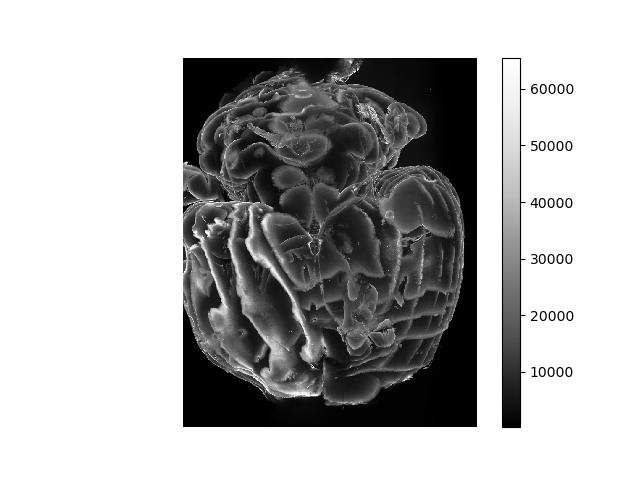
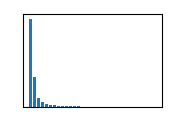

In [14]:
stackview.insight(brain_image)

## Freeing up memory

Before adding (new) data into memory, it can be helpful to free up space by deleting variables you are no longer using with `del`. You can also use Python's built-in garbage collector `gc` to manually force a cleanup of unreachable objects. This reduces the risk of memory overload. 

⚠️ Note: Be cautious when deleting variables - once deleted, you will need to re-run the earlier code to generate them again.

In [15]:
del brain_image

In [16]:
import gc
gc.collect()

8908